In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [15]:
import os
import torch
import torchvision

from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

# Dataset

In [16]:
class Face_Mask_Dataset(torch.utils.data.Dataset):
    def __init__(self, mode='train', transforms=None):
        self.img_dir = '/kaggle/input/face-mask-detection-dataset/Medical mask/Medical mask/Medical Mask/images'
        self.anno_dir = '/kaggle/input/face-mask-train/train.csv'
        self.annotations = pd.read_csv(self.anno_dir)
        self.annotations = self.annotations[self.annotations['classname']]
        # Randomize the images order
        self.images = np.random.permutation(self.annotations['name'].unique())
        # Return differents image list based on mode
        if mode == 'train':
            self.images = self.images[:-800]
        elif mode == 'val':
            self.images = self.images[-800:-400]
        else:
            self.images = self.images[-400:]
        self.transforms = transforms
        self.labels = {'face_no_mask': 1, 'face_with_mask': 2}
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        # Get image's name and open it
        image_name = self.images[idx]
        image = Image.open(os.path.join(self.img_dir, image_name))

        # Get bounding box coordinates and convert labels to numerical values
        annotations = self.annotations[self.annotations['name'] == image_name]
        boxes = annotations[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
        labels = annotations['classname'].values.tolist()
        labels  = [self.labels[label] for label in labels]
        
        # Convert Image and Annotations to tensors
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {'boxes': boxes, 'labels':labels}
        if self.transforms is not None:
            image = self.transforms(image)
        
        return image, target

In [19]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
])

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [21]:
EPOCHS = 10
BATCH_SIZE = 4

In [22]:
# Create Train/Val/Test datasets and dataloaders
train_dataset = Face_Mask_Dataset('train', transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

val_dataset = Face_Mask_Dataset('val', transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

test_dataset = Face_Mask_Dataset('test', transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

# Visualization

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Informations for visualization
label_info = {1:['face_no_mask', 'red'], 2:['face_with_mask', 'green']}

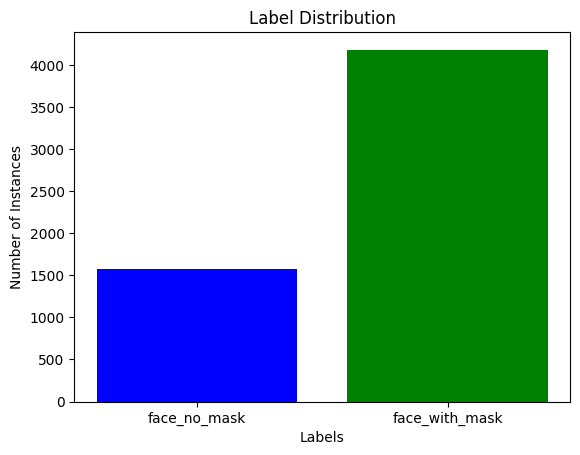

In [24]:
label_df = pd.read_csv('/kaggle/input/face-mask-detection-dataset/train.csv', usecols=['classname'])
label_counts = [label_df.value_counts()[label_info[label][0]] for label in label_info.keys()]

plt.bar([label_info[label][0] for label in label_info.keys()], label_counts, color=['red', 'green'])
plt.xlabel('Labels')
plt.ylabel('Number of Instances')
plt.title('Label Distribution')
plt.show()

In [25]:
def visualize(batch, label_info, gt=None):
    fig = plt.figure(figsize=(10, 8))
    
    for i in range(4):
        ax = fig.add_subplot(2, 2, i+1)
        
        # Get image and predictions from batch
        image = batch[0][i].cpu().permute(1, 2, 0)
        boxes = batch[1][i]['boxes'].cpu()
        labels = batch[1][i]['labels'].cpu()
        
        # Visualize predicted Bounding Boxes
        for j in range(len(boxes)):
            color =  label_info[labels[j].item()][1]
            rect = patches.Rectangle((boxes[j][0], boxes[j][1]), boxes[j][2]-boxes[j][0], boxes[j][3]-boxes[j][1], linewidth=1, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            
        # Visualize the Ground Truth boxes if provided
        if gt is not None:
            for j in range(len(gt[i]['boxes'])):
                gt_box = gt[i]['boxes'][j].cpu()
                rect = patches.Rectangle((gt_box[0], gt_box[1]), gt_box[2]-gt_box[0], gt_box[3]-gt_box[1], linewidth=1, edgecolor='blue', facecolor='none')
                ax.add_patch(rect)
        
        plt.imshow(image)
    
    # Legends
    handles = [patches.Patch(color=color, label=label) for label, color in label_info.values()]
    fig.legend(handles=handles, loc='upper right', fontsize=12, bbox_to_anchor=(0.91, 1))
    plt.show()

Training images: 3469
Validating images: 400
Testing images: 400


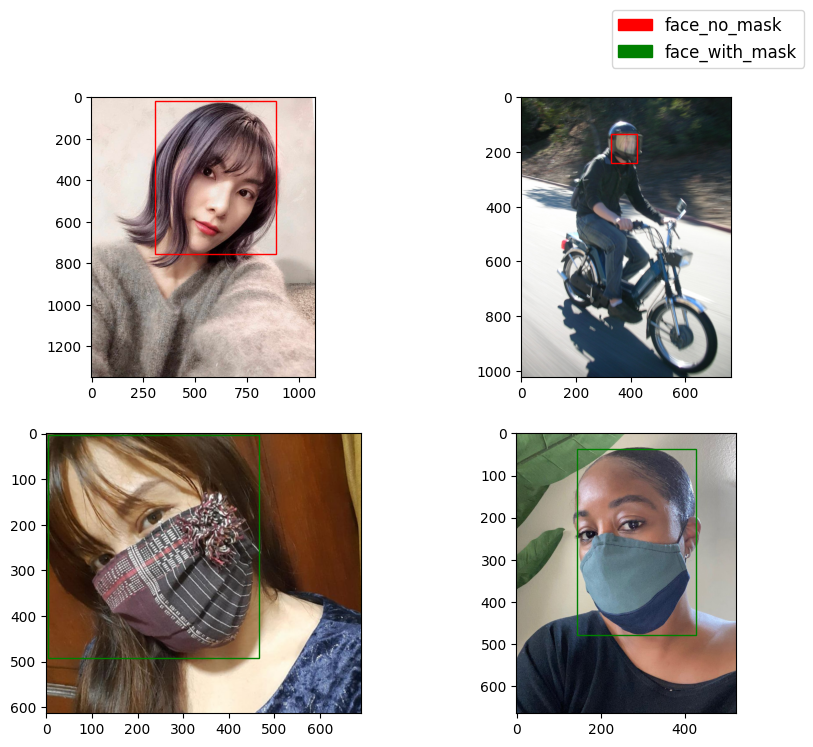

In [26]:
train_iter = iter(train_loader)
train_batch = next(train_iter)
print("Training images:", len(train_dataset))
print("Validating images:", len(val_dataset))
print("Testing images:", len(test_dataset))

visualize(train_batch, label_info)

# Model

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Get the backbone from torchvision
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights='FasterRCNN_ResNet50_FPN_Weights.DEFAULT', progress=True)

# Adjust the in/out parameters
num_classes = 3
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 169MB/s]  


In [29]:
model.to(device)
print(next(model.parameters()).device)

cuda:0


In [30]:
from torch.optim.lr_scheduler import StepLR
params = [param for param in model.parameters() if param.requires_grad == True]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training

In [31]:
!pip install pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 8.1 MB/s eta 0:00:00ta 0:00:01


In [32]:
from torchmetrics.detection import MeanAveragePrecision
from torchmetrics.detection import IntersectionOverUnion

# Create metric instances to evaluate the model
map_metric = MeanAveragePrecision(max_detection_thresholds=[1, 10, 150])
iou_metric = IntersectionOverUnion(iou_threshold=0.5, class_metrics=True, respect_labels=True)

In [33]:
train_losses = []
map_50 = []
map_75 = []
iou = []

for epoch in range(EPOCHS):
    # Training
    model.train()
    training_loss = 0.0
    
    for images, targets in train_loader:
        # Move images and annotations to gpu
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        training_loss += losses.item()
        
        #Backpropagation
        losses.backward()
        optimizer.step()
        optimizer.zero_grad()
    
    train_losses.append(training_loss/len(train_loader))
    print(f"Epochs: {epoch+1}")
    print(f"Training: Loss: {training_loss/len(train_loader):.5f}, "
          f"loss_classifier: {loss_dict['loss_classifier']:.5f}, loss_box_reg: {loss_dict['loss_box_reg']:.5f}, "
          f"loss_objectness: {loss_dict['loss_objectness']:.5f}, loss_rpn_box_reg: {loss_dict['loss_rpn_box_reg']:.5f}")

    # Validating
    model.eval()
    with torch.no_grad():

        for images, targets in val_loader:
            # Move images and annotations to gpu
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            
            # Update predictions and annotations to metrics
            map_metric.update(outputs, targets)
            iou_metric.update(outputs, targets)

        # Caculate metrics using updated predictions and annotations
        mAP = map_metric.compute()
        IoU = iou_metric.compute()
        
        map_50.append(mAP['map_50'].item())
        map_75.append(mAP['map_75'].item())
        iou.append(IoU['iou'].item())

        print(f"Validating: mAP 50: {mAP['map_50'].item():.5f}, mAP 75: {mAP['map_75'].item():.5f}, IoU: {IoU['iou'].item():.5f}")

Epochs: 1
Training: Loss: 0.1775, loss_classifier: 0.0058, loss_box_reg: 0.0204, loss_objectness: 0.0007, loss_rpn_box_reg: 0.0041
Validating: mAP 50: 0.9186, mAP 75: 0.7820, IoU: 0.8043
Epochs: 2
Training: Loss: 0.1284, loss_classifier: 0.0182, loss_box_reg: 0.0306, loss_objectness: 0.0004, loss_rpn_box_reg: 0.0005
Validating: mAP 50: 0.9472, mAP 75: 0.8036, IoU: 0.8365
Epochs: 3
Training: Loss: 0.1117, loss_classifier: 0.0264, loss_box_reg: 0.0908, loss_objectness: 0.0003, loss_rpn_box_reg: 0.0008
Validating: mAP 50: 0.9689, mAP 75: 0.8762, IoU: 0.8605
Epochs: 4
Training: Loss: 0.0998, loss_classifier: 0.0070, loss_box_reg: 0.0127, loss_objectness: 0.0002, loss_rpn_box_reg: 0.0005
Validating: mAP 50: 0.9763, mAP 75: 0.8853, IoU: 0.8664
Epochs: 5
Training: Loss: 0.0908, loss_classifier: 0.0673, loss_box_reg: 0.0620, loss_objectness: 0.0003, loss_rpn_box_reg: 0.0037
Validating: mAP 50: 0.9768, mAP 75: 0.8892, IoU: 0.8680
Epochs: 6
Training: Loss: 0.0841, loss_classifier: 0.0037, loss_b

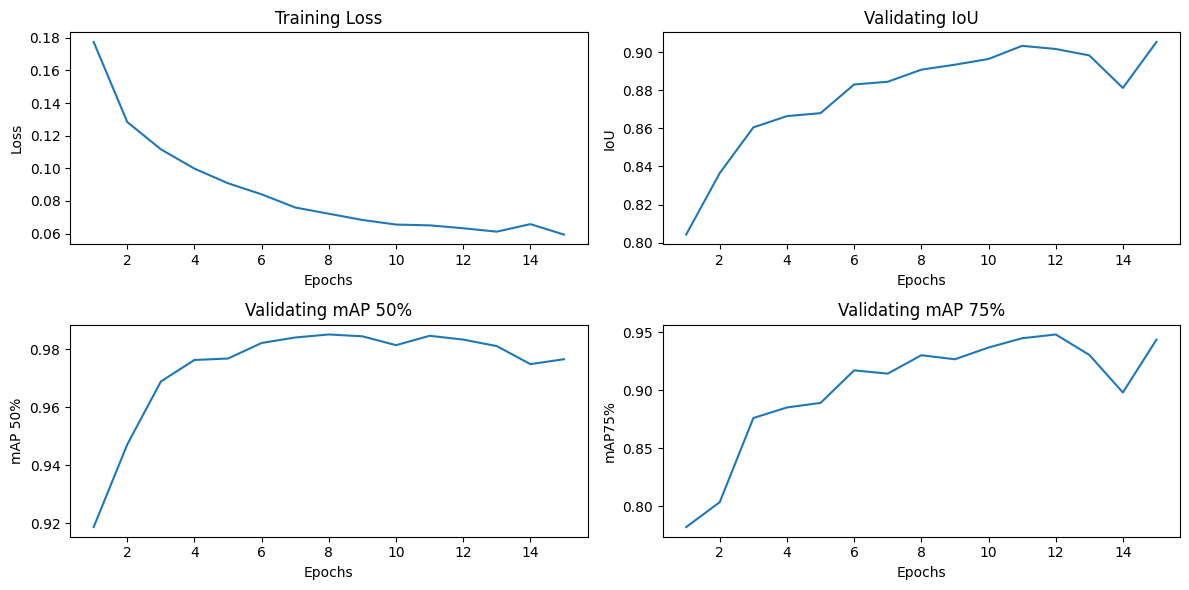

In [34]:
# Plot metrics
epochs = range(1, EPOCHS+1)
plt.figure(figsize=(12, 6))

metrics = [train_losses, iou, map_50, map_75]
xlabels = ['Loss', 'IoU', 'mAP 50%', 'mAP75%']
titles = ['Training Loss', 'Validating IoU', 'Validating mAP 50%', 'Validating mAP 75%']

for i in range(4):
    plt.subplot(2, 2, i+1)

    plt.plot(epochs, metrics[i], label=xlabels[i])
    plt.xlabel('Epochs')
    plt.ylabel(xlabels[i])
    plt.title(titles[i])
    
plt.tight_layout()
plt.show()

In [35]:
# Save the model
torch.save(model.state_dict(), '/kaggle/working/model.pth')

In [36]:
# state_dict = torch.load('/kaggle/input/fasterrcnn_face_mask_detection/pytorch/default/1/model.pth')
# model.load_state_dict(state_dict)

# Inference

In [40]:
# Reset metrics for Testing
map_metric.reset()
iou_metric.reset()
    
model.eval()
with torch.no_grad():
    
    for images, targets in test_loader:
        # Move images and annotations to gpu
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        outputs = model(images, targets)
            
        # Update predictions and annotations to metrics
        map_metric.update(outputs, targets)
        iou_metric.update(outputs, targets)
        
    # Caculate metrics using updated predictions and annotations
    mAP = map_metric.compute()
    IoU = iou_metric.compute()

    print(f"Testing: mAP 50: {mAP['map_50'].item():.4f}, mAP 75: {mAP['map_75'].item():.4f}, IoU: {IoU['iou'].item():.4f}")
    
    map_metric.reset()
    iou_metric.reset()

Testing: mAP 50: 0.9741, mAP 75: 0.9385, IoU: 0.9018


In [38]:
test_iter = iter(test_loader)
test_batch = next(test_iter)

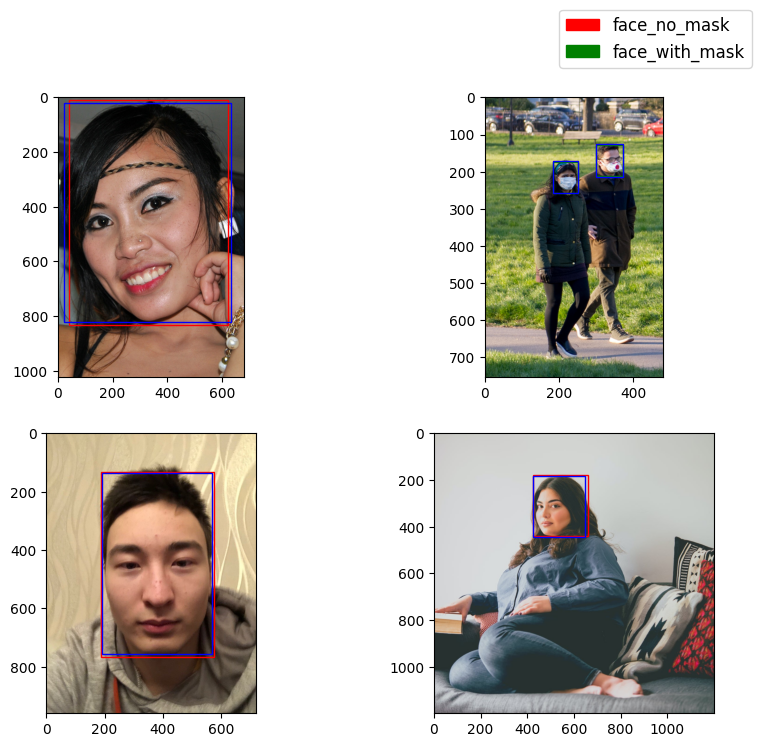

In [39]:
# Visualize predictions from testing dataset
model.eval()
with torch.no_grad():
    
    for images, targets in test_loader:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        outputs = model(images)
        break
        
visualize([images, outputs], label_info, gt=targets)